# Comparison of an SMPI trace with a real trace for HPL

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv')
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank', 'm', 'n', 'k']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_0.csv')
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_0.csv')
    return df, df_links

reality_file = 'grenoble_2018-12-13_1827231.zip'

trace_reality, link_reality = read_archive(reality_file, 'reality')
trace_reality.head()

# Mode: reality
	BLAS trace: 1996880 lines
	MPI  trace: 3591458 lines
Removed 1997408 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,end,function,k,kind,m,msg_size,n,rank,start,mode,rank+1
0,173.488034,dtrsm,-1.0,BLAS,2.0,-1,2.0,0,173.488,reality,1
1,173.488296,dgemm,2.0,BLAS,125054.0,-1,2.0,0,173.488,reality,1
2,173.489000,dtrsm,-1.0,BLAS,0.0,-1,2.0,0,173.489,reality,1
3,173.489000,dgemm,2.0,BLAS,125052.0,-1,0.0,0,173.489,reality,1
4,173.489002,dtrsm,-1.0,BLAS,4.0,-1,4.0,0,173.489,reality,1


In [2]:
trace_reality[trace_reality['function'] == 'MPI_Send'].head()

,end,function,k,kind,m,msg_size,n,rank,start,mode,rank+1
7,0.004260,MPI_Send,NaN,MPI,NaN,4,NaN,7,0.003872,reality,8
13,0.005625,MPI_Send,NaN,MPI,NaN,8,NaN,7,0.005624,reality,8
33,0.008382,MPI_Send,NaN,MPI,NaN,12,NaN,7,0.008380,reality,8
43,173.938106,MPI_Send,NaN,MPI,NaN,29983200,NaN,7,173.843800,reality,8
46,174.237909,MPI_Send,NaN,MPI,NaN,127943688,NaN,7,174.180120,reality,8


## Checking the parameters

In [3]:
read_csv(reality_file, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,2,4,1,2,2,1,0,8,1,32


In [4]:
for kind in trace_reality['kind'].unique():
    df = trace_reality[trace_reality['kind'] == kind]
    print(kind, df.start.min(), df.end.max())

BLAS 173.488 2600.290212
MPI 2.8999999999999997e-05 2843.532021


### Removing the initialization and the finalization in the traces

In [5]:
def split(df):
    return [df[df['rank'] == rank] for rank in df['rank'].unique()]

def crop(df, func_name):
    func_calls = df[df['function'] == func_name]
    assert len(func_calls) == 2
    start = func_calls['end'].min()
    end = func_calls['start'].max()
    return df[(df['start'] > start) & (df['end'] < end)]

def crop_all(df, func_name):
    df_ranks = [crop(tmp_df, func_name) for tmp_df in split(df)]
    df = pandas.concat(df_ranks)
    min_time = df['start'].min()
    df['start'] -= min_time
    df['end'] -= min_time
    return df

In [6]:
trace_reality = crop_all(trace_reality, 'MPI_Bcast')
print(trace_reality['start'].min(), trace_reality['end'].max())

0.0 2427.835838


In [7]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

In [8]:
def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

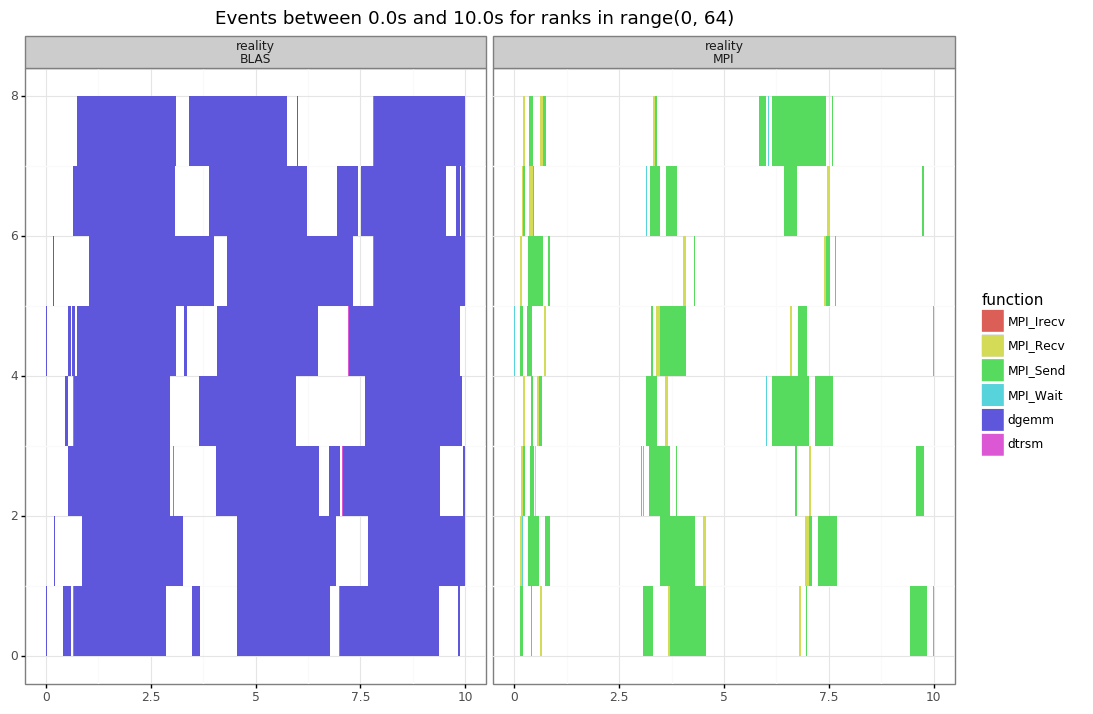

<ggplot: (8754409050453)>

In [9]:
plot_bounded(trace_reality, 0, 10, range(64))

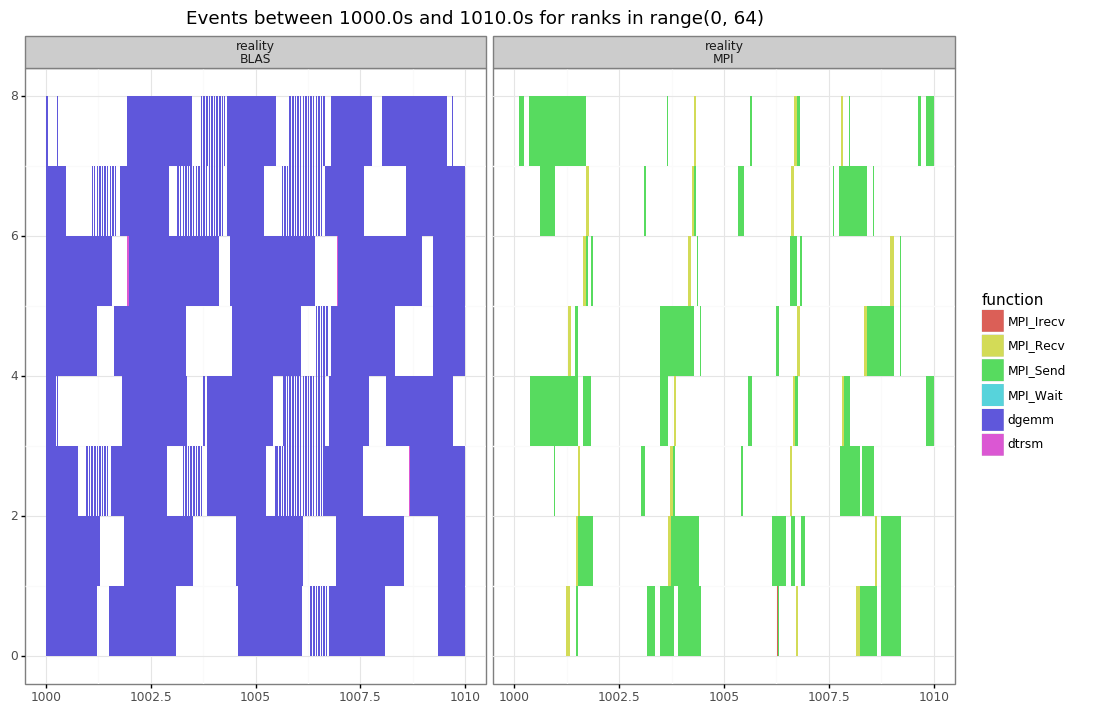

<ggplot: (-9223363282433822541)>

In [10]:
plot_bounded(trace_reality, 1000, 1010, range(64))

## Computing the average "bandwidth"

Here I divide the number of bytes sent (resp. received) by the time spent in MPI_Send (resp. MPI_Recv).
This does not make any sense for asynchronous calls, but this is roughly equal to the bandwidth for synchronous calls (neglecting the latency).

In [11]:
df = trace_reality[trace_reality.function.isin(['MPI_Recv', 'MPI_Send'])].copy()
df['duration'] = df['end'] - df['start']
df = df.groupby(['rank', 'mode', 'function']).sum().reset_index()
df['bw'] = df['msg_size'] / df['duration']
df[['rank', 'function', 'msg_size', 'duration', 'bw']]

,rank,function,msg_size,duration,bw
0,0,MPI_Recv,93900397128,69.759436,1.346060e+09
1,0,MPI_Send,141034420632,519.576278,2.714412e+08
2,1,MPI_Recv,93900526280,55.287875,1.698393e+09
3,1,MPI_Send,140867410512,521.853167,2.699369e+08
4,2,MPI_Recv,93964491344,51.041455,1.840945e+09
5,2,MPI_Send,140874148024,324.223773,4.344967e+08
6,3,MPI_Recv,93964491344,51.749964,1.815740e+09
7,3,MPI_Send,140873769768,491.588943,2.865682e+08
8,4,MPI_Recv,93796457032,61.785197,1.518106e+09
9,4,MPI_Send,140831719792,446.548004,3.153787e+08


In [12]:
df.groupby('function')[['bw']].mean()

,bw
function,
MPI_Recv,1.668273e+09
MPI_Send,4.099958e+08


We see here that the "average bandwidth" is between 500 MB/s and 1GB/s in reality. The Omnipath links that we have should be 100Gb/s (12.5 GB/s).

## Counting the number of events

In [13]:
trace_reality[['function', 'mode', 'rank']].groupby('function').count()

,mode,rank
function,,
MPI_Irecv,519512,519512
MPI_Recv,17584,17584
MPI_Send,537096,537096
MPI_Wait,519512,519512
dgemm,998434,998434
dtrsm,998434,998434


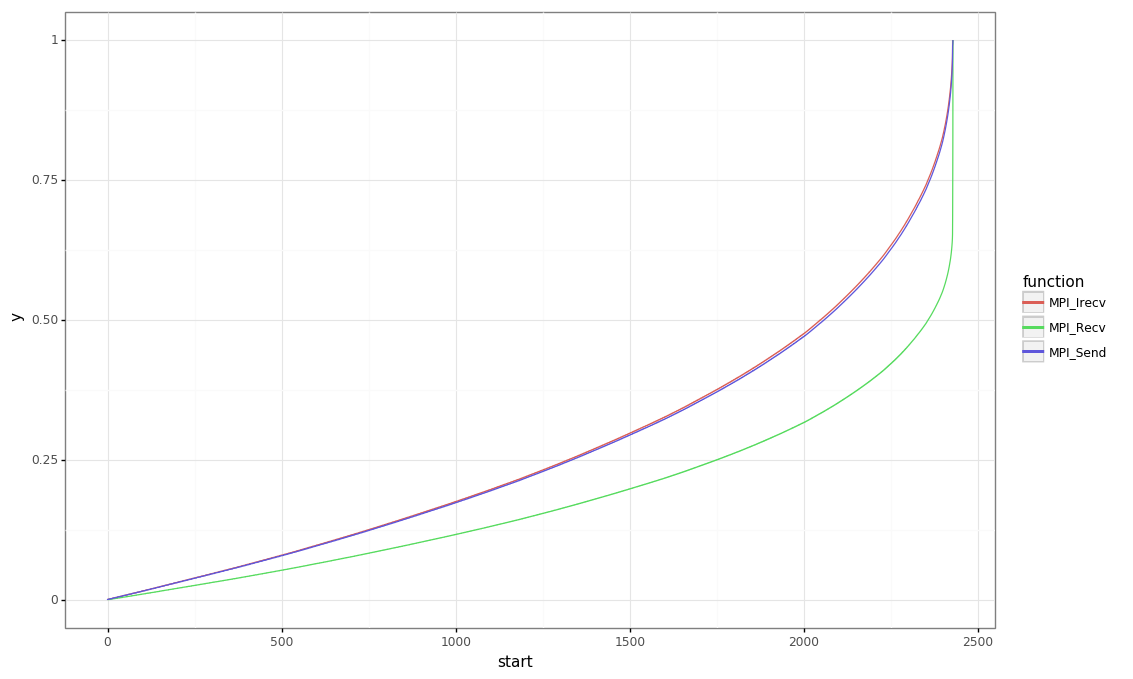

<ggplot: (8754421235057)>

In [14]:
ggplot(trace_reality[trace_reality.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + theme_bw()

## Plotting the BLAS calls

In [15]:
def plot_blas(df, function):
    df = df[df.function == function].copy()
    if function == 'dgemm':
        df['size_product'] = df.m * df.n * df.k
    else:
        df['size_product'] = df.m * df.n**2
    df['duration'] = df['end'] - df['start']
    plot = ggplot(df, aes(x='size_product', y='duration', color='factor(rank)', group='rank'))
    return plot + geom_point(alpha=0.1) + geom_smooth(method='lm') + theme_bw() + ggtitle('Durations of the calls to %s' % function)

In [16]:
def plot_blas(df, function):
    df = df[df.function == function].copy()
    if function == 'dgemm':
        df['size_product'] = df.m * df.n * df.k
    else:
        df['size_product'] = df.m * df.n**2
    df['duration'] = df['end'] - df['start']
    plot = ggplot(df, aes(x='size_product', y='duration', color='factor(rank)', group='rank'))
    return plot + geom_point(alpha=0.1) + geom_smooth(method='lm') + theme_bw() + ggtitle('Durations of calls to %s' % function)

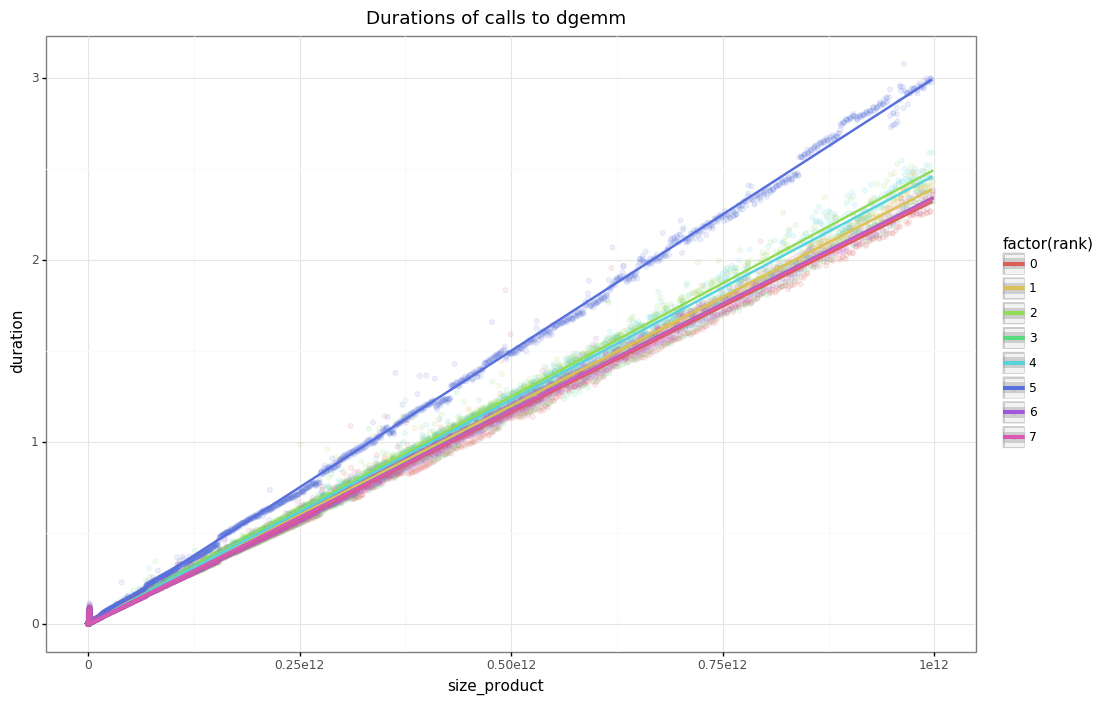

<ggplot: (-9223363282433550511)>

In [17]:
plot_blas(trace_reality, 'dgemm')

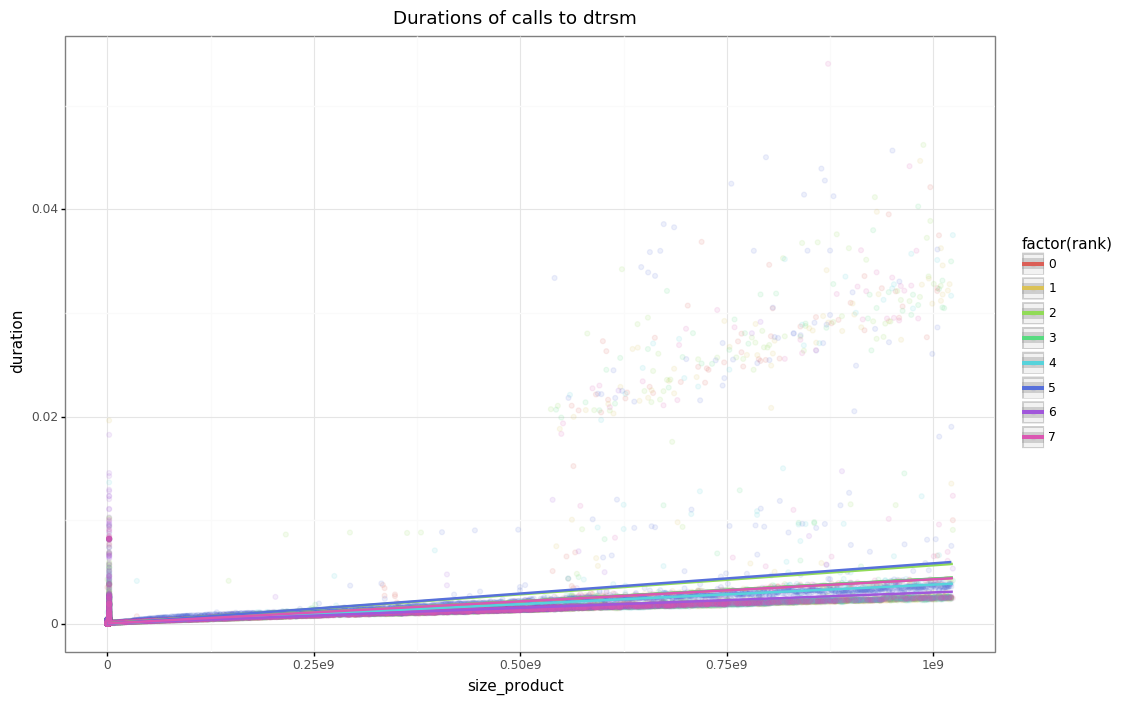

<ggplot: (-9223363282433568533)>

In [18]:
plot_blas(trace_reality, 'dtrsm')

In [19]:
trace_reality['duration'] = trace_reality['end'] - trace_reality['start']
trace_reality[trace_reality['kind'] == 'BLAS'].groupby(['function', 'rank'])[['duration']].sum()

duration
function rank             
dgemm    0     1543.712947
         1     1565.686721
         2     1771.659824
         3     1597.393918
         4     1629.042200
         5     1952.639491
         6     1698.429131
         7     1605.184566
dtrsm    0        5.716554
         1        4.950371
         2       13.194031
         3        8.171883
         4        5.120743
         5        6.346669
         6       12.166174
         7        8.942794

In [20]:
import statsmodels.formula.api as sm

def compute_reg(df, function):
    df = df[df.function == function].copy()
    if function == 'dgemm':
        df['size_product'] = df.m * df.n * df.k
    else:
        df['size_product'] = df.m * df.n**2
    df['duration'] = df['end'] - df['start']
    regressions = []
    for rank in trace_reality['rank'].unique():
        reg = sm.ols(data=df[df['rank'] == rank], formula='duration ~ size_product').fit()
        regressions.append({
            'rank': rank,
            'intercept': reg.params['Intercept'],
            'coefficient': reg.params['size_product'],
        })
    return pandas.DataFrame(regressions)

In [21]:
param_dgemm = compute_reg(trace_reality, 'dgemm')
param_dgemm

,coefficient,intercept,rank
0,2.323719e-12,0.000340,0
1,2.394360e-12,0.000098,1
2,2.494063e-12,0.000823,2
3,2.345799e-12,0.000453,3
4,2.462303e-12,0.000316,4
5,2.999396e-12,0.000037,5
6,2.344958e-12,0.000872,6
7,2.338696e-12,0.000614,7


In [22]:
param_dtrsm = compute_reg(trace_reality, 'dtrsm')
param_dtrsm

,coefficient,intercept,rank
0,4.330126e-12,0.000016,0
1,4.319634e-12,0.000008,1
2,5.607205e-12,0.000042,2
3,4.338905e-12,0.000025,3
4,3.765359e-12,0.000017,4
5,5.830476e-12,0.000007,5
6,2.984086e-12,0.000046,6
7,4.266092e-12,0.000034,7


In [23]:
def compute_C_parameters(df, function):
    reg = compute_reg(df, function)
    result = [
        'int rank;',
        'MPI_Comm_rank(MPI_COMM_WORLD, &rank);',
        'switch(rank) {',
    ]
    for rank in sorted(reg['rank']):
        row = reg[reg['rank'] == rank]
        coeff = row['coefficient'].unique()[0]
        inter = row['intercept'].unique()[0]
        result.append('    case %d:' % rank)
        result.append('        %s_coefficient=%e;' % (function, coeff))
        result.append('        %s_intercept=%e;' % (function, inter))
        result.append('        break;')
    result.append('    default: exit(1);')
    result.append('}')
    result = ['+        ' + line + '\\\n' for line in result]
    return ''.join(result)

def get_patch(df):
    add_dgemm = compute_C_parameters(df, 'dgemm')
    add_dtrsm = compute_C_parameters(df, 'dtrsm')
    return r'''
diff --git a/include/hpl_blas.h b/include/hpl_blas.h
index 741b225..3ced2e4 100644
--- a/include/hpl_blas.h
+++ b/include/hpl_blas.h
@@ -228,8 +228,43 @@ static double dgemm_intercept = -1;
 #pragma message "[SMPI] Using smpi_execute for HPL_dgemm."
 #define  HPL_dgemm(layout, TransA, TransB, M, N, K, alpha, A, lda, B, ldb, beta, C, ldc)  ({\
     if(dgemm_coefficient < 0 || dgemm_intercept < 0) {\
-        dgemm_coefficient = get_param("SMPI_DGEMM_COEFFICIENT");\
-        dgemm_intercept = get_param("SMPI_DGEMM_INTERCEPT");\
%s     }\
     double expected_time;\
     expected_time = dgemm_coefficient*((double)(M))*((double)(N))*((double)(K)) + dgemm_intercept;\
@@ -257,8 +292,43 @@ static double dtrsm_intercept = -1;
 #pragma message "[SMPI] Using smpi_execute for HPL_dtrsm."
 #define HPL_dtrsm(layout, Side, Uplo, TransA, Diag, M, N, alpha, A, lda, B, ldb) ({\
     if(dtrsm_coefficient < 0 || dtrsm_intercept < 0) {\
-        dtrsm_coefficient = get_param("SMPI_DTRSM_COEFFICIENT");\
-        dtrsm_intercept = get_param("SMPI_DTRSM_INTERCEPT");\
%s     }\
     double expected_time;\
     if((Side) == HplLeft) {\
    ''' % (add_dgemm, add_dtrsm)

print(get_patch(trace_reality))


diff --git a/include/hpl_blas.h b/include/hpl_blas.h
index 741b225..3ced2e4 100644
--- a/include/hpl_blas.h
+++ b/include/hpl_blas.h
@@ -228,8 +228,43 @@ static double dgemm_intercept = -1;
 #pragma message "[SMPI] Using smpi_execute for HPL_dgemm."
 #define  HPL_dgemm(layout, TransA, TransB, M, N, K, alpha, A, lda, B, ldb, beta, C, ldc)  ({\
     if(dgemm_coefficient < 0 || dgemm_intercept < 0) {\
-        dgemm_coefficient = get_param("SMPI_DGEMM_COEFFICIENT");\
-        dgemm_intercept = get_param("SMPI_DGEMM_INTERCEPT");\
+        int rank;\
+        MPI_Comm_rank(MPI_COMM_WORLD, &rank);\
+        switch(rank) {\
+            case 0:\
+                dgemm_coefficient=2.323719e-12;\
+                dgemm_intercept=3.401798e-04;\
+                break;\
+            case 1:\
+                dgemm_coefficient=2.394360e-12;\
+                dgemm_intercept=9.812780e-05;\
+                break;\
+            case 2:\
+                dgemm_coefficient=2.494063e-12;\
+           